In [1]:
import os

os.environ["HF_HOME"] = "/DATA2/HuggingFace"

from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
import numpy as np


/home/mou/anaconda3/envs/deephallu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.to("cuda:0")

# prepare image and text prompt, using the appropriate prompt template

# image_path = "/home/mou/Projects/DeepHallu/data/examples/image.jpeg"
# image = Image.open(image_path)
# question = "What is shown in this image?"

from datasets import load_dataset
llava_bench = load_dataset("lmms-lab/llava-bench-in-the-wild")
sample = llava_bench['train'][0]
image = sample['image']
question = sample['question']
print(question)
# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": question},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")
# # Explore the inputs
# # image size
# print(f"image size: {image.size}")
# # inputs contains:
# # - input_ids
# # - attention_mask
# # - pixel_values
# # - image_sizes
# for k, v in inputs.items():
#     print(k, v.shape)
# print(f"inputs: {inputs['image_sizes']}")
# # Decode and print the input_ids as text for inspection
# decoded_input = processor.tokenizer.decode(input_ids, skip_special_tokens=False)
# print("Decoded input_ids:\n", decoded_input)
# image_token_id = model.config.image_token_id
# input_ids = inputs["input_ids"][0]
# image_token_indices = (input_ids == image_token_id).nonzero(as_tuple=True)[0].tolist()
# print("Indices of image_token_id in input_ids:", image_token_indices)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s]


What is the name of this famous sight in the photo?


In [9]:

for k, v in inputs.items():
    print(k, v.shape)

input_ids torch.Size([1, 2559])
attention_mask torch.Size([1, 2559])
pixel_values torch.Size([1, 5, 3, 336, 336])
image_sizes torch.Size([1, 2])


In [8]:
print(f"inputs: {inputs['image_sizes']}")
# print(processor.tokenizer.decode(inputs["input_ids"][0]))
print(prompt)

inputs: tensor([[2180, 2560]], device='cuda:0')
[INST] <image>
What is the name of this famous sight in the photo? [/INST]


In [7]:
# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST]  
What is the name of this famous sight in the photo? [/INST] The image you've provided appears to show Diamond Head, a famous landmark located on the island of Oahu in Hawaii. It's a volcanic crater that has been eroded by wind and rain over the years, creating a distinctive shape that resembles a diamond. The crater is a popular tourist attraction and offers panoramic views of Honolulu and the Pacific Ocean. 


In [30]:

for k, v in inputs.items():
    print(k, v.shape)
image_token_id = model.config.image_token_id
input_ids = inputs["input_ids"][0]
image_token_indices = (input_ids == image_token_id).nonzero(as_tuple=True)[0].tolist()
print(f"Number of image tokens: {len(image_token_indices)}")

input_ids torch.Size([1, 2559])
attention_mask torch.Size([1, 2559])
pixel_values torch.Size([1, 5, 3, 336, 336])
image_sizes torch.Size([1, 2])
Number of image tokens: 2536


In [31]:
# print(model.config)

=== LLaVA Image Processing Analysis ===
=== Image Processor Information ===
Processed tensor shape: torch.Size([1, 5, 3, 336, 336])
Processed tensor dtype: torch.float32
Original image size: (2560, 2180)
Image mode: RGB
Target size: {'shortest_edge': 336}
Crop size: {'height': 336, 'width': 336}
Processed image shape: torch.Size([1, 5, 3, 336, 336])
5D tensor detected: batch=1, num_images=5, channels=3, height=336, width=336
Using first image scale for position calculation
Original image size: 2560x2180
Processed image size: 336x336
Calculated grid size: 24x24

Total patches: 576

First 5 patch positions:
Patch 0: Grid(0, 0) -> Original(0, 0, 106, 90)
Patch 1: Grid(0, 1) -> Original(106, 0, 213, 90)
Patch 2: Grid(0, 2) -> Original(213, 0, 320, 90)
Patch 3: Grid(0, 3) -> Original(320, 0, 426, 90)
Patch 4: Grid(0, 4) -> Original(426, 0, 533, 90)


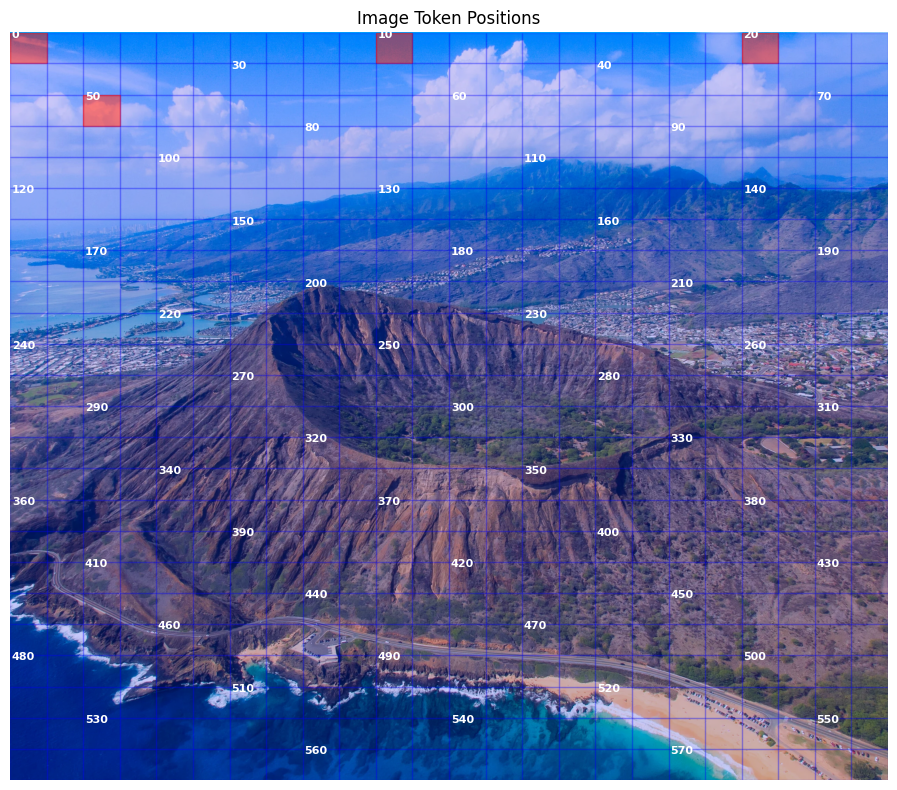

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_image_token_positions(processor, image, grid_size=None):
    """
    获取图像token在原始图像中的位置，支持多维张量
    """
    # 获取处理后的图像尺寸
    processed_inputs = processor.image_processor(image, return_tensors="pt")
    processed_image = processed_inputs["pixel_values"]
    
    # 检查维度并正确解包
    print(f"Processed image shape: {processed_image.shape}")
    
    if len(processed_image.shape) == 5:
        # [batch, num_images, channels, height, width] - LLaVA-Next多尺度处理
        batch_size, num_images, channels, proc_height, proc_width = processed_image.shape
        print(f"5D tensor detected: batch={batch_size}, num_images={num_images}, channels={channels}, height={proc_height}, width={proc_width}")
        print(f"Using first image scale for position calculation")
        
    elif len(processed_image.shape) == 4:
        # [batch, channels, height, width]
        _, channels, proc_height, proc_width = processed_image.shape
        print(f"4D tensor: channels={channels}, height={proc_height}, width={proc_width}")
        
    elif len(processed_image.shape) == 3:
        # [channels, height, width]
        channels, proc_height, proc_width = processed_image.shape
        print(f"3D tensor: channels={channels}, height={proc_height}, width={proc_width}")
        
    else:
        raise ValueError(f"Unexpected image shape: {processed_image.shape}")
    
    # 获取原始图像尺寸
    orig_width, orig_height = image.size
    print(f"Original image size: {orig_width}x{orig_height}")
    print(f"Processed image size: {proc_width}x{proc_height}")
    
    # 如果没有提供grid_size，使用默认的CLIP设置
    if grid_size is None:
        # CLIP ViT通常使用336x336的输入，patch_size=14
        patch_size = 14
        grid_size = proc_height // patch_size
        print(f"Calculated grid size: {grid_size}x{grid_size}")
    
    # 计算每个patch在原始图像中的位置
    patch_positions = []
    
    for i in range(grid_size):
        for j in range(grid_size):
            # 在处理后图像中的位置
            proc_y_start = i * (proc_height // grid_size)
            proc_y_end = (i + 1) * (proc_height // grid_size)
            proc_x_start = j * (proc_width // grid_size)
            proc_x_end = (j + 1) * (proc_width // grid_size)
            
            # 映射到原始图像
            orig_y_start = int(proc_y_start * orig_height / proc_height)
            orig_y_end = int(proc_y_end * orig_height / proc_height)
            orig_x_start = int(proc_x_start * orig_width / proc_width)
            orig_x_end = int(proc_x_end * orig_width / proc_width)
            
            patch_positions.append({
                'patch_id': i * grid_size + j,
                'grid_pos': (i, j),
                'orig_bbox': (orig_x_start, orig_y_start, orig_x_end, orig_y_end),
                'proc_bbox': (proc_x_start, proc_y_start, proc_x_end, proc_y_end)
            })
    
    return patch_positions

def get_image_processor_info(processor, image):
    """
    获取图像处理器的详细信息
    """
    # 处理图像
    processed_inputs = processor.image_processor(image, return_tensors="pt")
    processed_image = processed_inputs["pixel_values"]
    
    print("=== Image Processor Information ===")
    print(f"Processed tensor shape: {processed_image.shape}")
    print(f"Processed tensor dtype: {processed_image.dtype}")
    print(f"Original image size: {image.size}")
    print(f"Image mode: {image.mode}")
    
    # 获取处理器配置
    if hasattr(processor.image_processor, 'size'):
        print(f"Target size: {processor.image_processor.size}")
    if hasattr(processor.image_processor, 'crop_size'):
        print(f"Crop size: {processor.image_processor.crop_size}")
    if hasattr(processor.image_processor, 'patch_size'):
        print(f"Patch size: {processor.image_processor.patch_size}")
    
    return processed_inputs

def visualize_image_tokens(image, positions, token_ids_to_highlight=None, figsize=(12, 8)):
    """
    可视化图像token在原始图像中的位置
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image)
    
    # 绘制每个patch的边界
    for pos in positions:
        x_start, y_start, x_end, y_end = pos['orig_bbox']
        
        # 选择颜色
        if token_ids_to_highlight and pos['patch_id'] in token_ids_to_highlight:
            color = 'red'
            alpha = 0.5
        else:
            color = 'blue'
            alpha = 0.2
        
        # 绘制矩形
        rect = patches.Rectangle(
            (x_start, y_start), 
            x_end - x_start, 
            y_end - y_start,
            linewidth=1, 
            edgecolor=color, 
            facecolor=color, 
            alpha=alpha
        )
        ax.add_patch(rect)
        
        # 添加patch ID标签（仅显示部分以避免拥挤）
        if pos['patch_id'] % 10 == 0 or (token_ids_to_highlight and pos['patch_id'] in token_ids_to_highlight):
            ax.text(x_start + 5, y_start + 15, str(pos['patch_id']), 
                    color='white', fontsize=8, weight='bold')
    
    ax.set_title("Image Token Positions")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_llava_image_processing(processor, image_path):
    """
    完整分析LLaVA图像处理过程
    """
    # 加载图像
    if isinstance(image_path, str):
        image = Image.open(image_path)
    else:
        image = image_path
    
    print("=== LLaVA Image Processing Analysis ===")
    
    # 1. 获取处理器信息
    processed_inputs = get_image_processor_info(processor, image)
    
    # 2. 获取token位置
    try:
        positions = get_image_token_positions(processor, image)
        print(f"\nTotal patches: {len(positions)}")
        
        # 显示前几个位置信息
        print("\nFirst 5 patch positions:")
        for pos in positions[:5]:
            print(f"Patch {pos['patch_id']}: Grid{pos['grid_pos']} -> Original{pos['orig_bbox']}")
        
        # 3. 可视化
        visualize_image_tokens(image, positions, token_ids_to_highlight=[0, 10, 20, 50])
        
        return {
            'positions': positions,
            'processed_inputs': processed_inputs,
            'grid_size': int(np.sqrt(len(positions)))
        }
        
    except Exception as e:
        print(f"Error getting positions: {e}")
        return {
            'processed_inputs': processed_inputs,
            'error': str(e)
        }
    
# 使用示例
# positions = get_image_token_positions(processor, image)
# for pos in positions[:5]:  # 显示前5个
#     print(f"Patch {pos['patch_id']}: Grid({pos['grid_pos']}) -> Original({pos['orig_bbox']})")
positions = analyze_llava_image_processing(processor, image)

In [33]:
special_image_mask = (input_ids == model.config.image_token_id).unsqueeze(-1)
print(special_image_mask.shape)
print(special_image_mask)

torch.Size([2559, 1])
tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]], device='cuda:0')


In [34]:
llava_next_output = model.generate(**inputs)
print(llava_next_output.shape)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


torch.Size([1, 2579])


In [35]:
llava_next_output_with_past = model.generate(
    **inputs,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    return_dict_in_generate=True,  # 返回字典格式而不是仅仅token IDs
    output_scores=True,           # 可选：输出生成分数
    output_attentions=True,     # 可选：输出注意力权重
    output_hidden_states=True,  # 可选：输出隐藏状态
)
for k, v in llava_next_output_with_past.items():
    print(k)


sequences
scores
attentions
hidden_states
past_key_values


In [36]:
processor.decode(llava_next_output_with_past["sequences"][0], skip_special_tokens=True)

"[INST]  \nWhat is the name of this famous sight in the photo? [/INST] The image you've provided appears to show Diamond Head, a famous landmark located on the island"

In [37]:
print(llava_next_output_with_past["sequences"].shape)

torch.Size([1, 2579])
